# Minimum Workable Implementation (MWI) for divergence-free Neural Networks (dfNNs)

- The original paper refers to this as *Neural Conservation Laws* (NCL)
- The official implementation by facebookresearch can he found [here](https://github.com/facebookresearch/neural-conservation-law)
    - The relevant model in under [jax > models.py](https://github.com/facebookresearch/neural-conservation-law/blob/main/jax/models.py)
- [This notebook by swsharma was very helpful](https://github.com/smsharma/neural-conservation-laws/blob/main/demo.ipynb)

In [1]:
# /home/kim/ice_thickness/.conda has these all installed now

# pip install jax/conda install jax
import jax
import jax.numpy as jnp
from jax import jit, vmap
# Jacobian forward and reverse
from jax import jacfwd, jacrev, grad, jvp

import numpy as np

# pip install flax/conda install flax
# NN library for jax
import flax.linen as nn

# pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# pip install einops/conda install einops
from einops import rearrange

Start by defining an arbitrary vector field $\mathbf{v}: \mathbb{R}^n \rightarrow \mathbb{R}^n$.

In [2]:
dims = 2

# f is a subclass of flax.linen.Module i.e. nn.Module
class b(nn.Module):
    """ 
    Pass X through a NN to generate an arbitrary vector field R^d -> R^d
    Input: vector of size dims
    (not for batch mode but for single point input)
    Output: b (in line with notation in paper, same dims as input)
    """
    # compact definition of NN layers
    @nn.compact
    def __call__(self, x, d_hidden = 128):
        x = nn.Dense(dims)(x)
        x = nn.gelu(x)
        x = nn.Dense(d_hidden)(x)
        x = nn.gelu(x)
        x = nn.Dense(d_hidden)(x)
        x = nn.gelu(x)
        x = nn.Dense(dims)(x)
        return x

# create an instance of class b
model = b()

# generate two 2D random keys (that are statistically independent) to make it reproducable 
# 34 is the seed
key1, key2 = jax.random.split(jax.random.PRNGKey(21))
# key1, key2 = jax.random.split(jax.random.PRNGKey(34))

# generate random single input point x of shape (2,)
x = jax.random.normal(key1, (dims,))
# params is a dictionary containing all initial parameters
params = model.init(key2, x)

def b_for_jac(x):
    """ 
    Helper function that applies the model to x
    """
    return model.apply(params, x)

In [3]:
# Pass a single point through the network
b_for_jac(x)

DeviceArray([-0.08072662,  0.01652612], dtype=float32)

## Input meshgrids x

In [4]:
# Divergence plot mesh
n_grid = 100
extent = 1

# x_ary is shape (100,) from -1 to 1
x_ary = jnp.linspace(-extent, extent, n_grid)

# meshgrid outputs (100, 100) and (100, 100)
# array turns list into array, transpose to have 2D last (100, 100, 2)
# rearrange reshapes to (10000, 2) (flattens the 2D)
x_mesh = rearrange(jnp.array(jnp.meshgrid(x_ary, x_ary)).T, "x y d -> (x y) d")

# Repeat for quiver plot mesh with slightly coarser grid
n_grid_quiver = 20

# x_ary_quiver.shape = (20,)
x_ary_quiver = jnp.linspace(-extent, extent, n_grid_quiver)
x_grid_quiver, y_grid_quiver = jnp.meshgrid(x_ary_quiver, x_ary_quiver)
# flatten each and concat
# x_mesh_quiver.shape = (400, 2)
# x_mesh_quiver[:, 0] is x, where the 
x_mesh_quiver = jnp.concatenate([x_grid_quiver.reshape(-1)[:, None], y_grid_quiver.reshape(-1)[:, None]], axis = 1)
# previous code:
# x_mesh_quiver = rearrange(jnp.array(jnp.meshgrid(x_ary_quiver, y_ary_quiver)).T, "x y d -> (x y) d")

# Plot b (NN-generated vector field)

Text(0.5, 1.0, 'div b (x)')

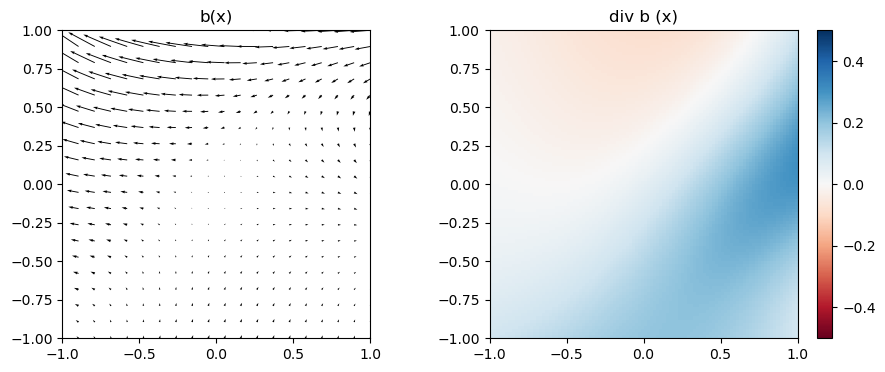

In [5]:
# keep the figuresize to both are equal
fig, ax = plt.subplots(1, 2, figsize = (11, 4))

# Quiver plot

# f_for_jac(x_mesh_quiver) has shape (400, 2)
# vmap applies b_for_jac to each element of x_mesh_quiver
# vmap(b_for_jac)(x_mesh_quiver) == f_for_jac(x_mesh_quiver) but vmaps uses parallel batch computing
# T transposes so that the dimensions are upfront, i.e. (2, 400) for U and V respectively
U, V = vmap(b_for_jac)(x_mesh_quiver).T
X, Y = x_grid_quiver, y_grid_quiver
ax[0].quiver(X, Y, U, V)
ax[0].set_aspect(1.)
ax[0].set_title("b(x)")
# ax[0].set_title(r"$b(\vec x)$")
ax[0].set_xlim(-extent, extent)
ax[0].set_ylim(-extent, extent)

# Divergence
# without vmap, jacfwd(f_for_jac)(x_mesh) would be too slow
# vmap(jacfwd(f_for_jac))(x_mesh) produces (10000, 2, 2) where every 2x2 matrix is the Jacobian of f_for_jac at a point
# trace over the second and third trace of the input tensor
im = ax[1].imshow(rearrange(jnp.trace(vmap(jacfwd(b_for_jac))(x_mesh), axis1 = 1, axis2 = 2), 
                            "(x y) -> x y", x = n_grid), 
                            vmin = -0.5, vmax = 0.5, 
                            cmap = 'RdBu', 
                            extent = [-extent, extent, -extent, extent], 
                            origin = 'lower')

fig.colorbar(im, ax = ax[1])
ax[1].set_title("div b (x)")

Negative divergence: sink  
Positive divergence: source

# Vector field construction

- b = NN(x) 
    - b is the same size as x, so (N, 2)
- Jb = Jacobian(b (as function))(x)
- A = Jb - Jb.T

In [15]:
# this corresponds to DivFreeImplicit(object) in https://github.com/facebookresearch/neural-conservation-law/blob/main/jax/models.py
def A_vectorfield_construction(x):
    """ 
    Maps a point in R ^ d to an antisymmetric matrix in R ^ (d x d)
    i.e. a (x, y) point to a 2x2 matrix with zeros on the diagonal and pos and neg on the off-diagonal
    """
    # functional Jacobian 
    # Jb is just (2, 2)
    Jb = jacfwd(b_for_jac)(x)
    # generate the antisymmetric matrix  
    A = Jb - Jb.T
    # A here has shape (N_flat, 2, 2)
    return A

def v_vectorfield_construction(x):
    """
    Target divergenceless field R^(d x d) -> R^d; Eq. (4) of 2210.06564
    """
    # (A)(x) has shape (2, 2)
    # jacfwd(A)(x) has shape (2, 2, 2) and for each of the first dimensions, we derive (2, 2) matrices derived from [0, :, :] 
    # and [1, :, :] we sum the diagonal (the trace)
    return jnp.trace(jacfwd(A_vectorfield_construction)(x), axis1 = 1, axis2 = 2)

In [16]:
vmap(A_vectorfield_construction)(x_mesh_quiver).shape

(400, 2, 2)

In [29]:
N = x_mesh_quiver.shape[0]
N_sqrt = jnp.sqrt(N)
N_upper = N_sqrt * N_sqrt / 2 - N_sqrt / 2

In [ ]:
print("Size of NN output (b) for vector field:", N * 2) # A still is N * 2 * 2
print("Size of NN output (U to make A) for matrix field:", N_upper * 2 * 2)

Size of NN output for vector field: 800
Size of NN output for matrix field: 760.0


(A)(x) 
(2, 2)
Array([[ 0.        ,  0.01331194],
       [-0.01331194,  0.        ]], dtype=float32)

jacfwd(A)(x)
(2, 2, 2)
Array([[[ 0.        ,  0.        ],
        [ 0.14629462,  0.28859383]],

       [[-0.14629462, -0.28859383],
        [ 0.        ,  0.        ]]], dtype=float32)

jnp.trace(jacfwd(A)(x), axis1 = 1, axis2 = 2)
(2,)
Array([ 0.28859383, -0.14629462], dtype=float32)

where 
jacfwd(A)(x)[0, :, :] selects the first element (0) along the first axis, reducing the shape from (2,2,2) → (2,2).
Array([[0.        , 0.        ],
       [0.14629462, 0.28859383]], dtype=float32) to 0.28

jacfwd(A)(x)[1, :, :]
Array([[-0.14629462, -0.28859383],
       [ 0.        ,  0.        ]], dtype=float32) so -0.14


# Understanding the trace indexing

The second and third axes (axis1 = 1, axis2 = 2) represent the rows and columns of each matrix.
The first axis (axis = 0) represents two separate matrices. These parameters tell jnp.trace which two axes to treat as the rows and columns of the matrices whose traces we want to compute.

https://docs.jax.dev/en/latest/_autosummary/jax.numpy.trace.html

Let the Jacobian of \( A \) at \( x \) be:

$\text{jacfwd}$(A)(x) =
\begin{bmatrix}
\begin{bmatrix} 0.00 & 0.00 \\ 0.14 & 0.28 \end{bmatrix},  
\begin{bmatrix} -0.14 & -0.28 \\ 0.00 & 0.00 \end{bmatrix}
\end{bmatrix}

$\text{jacfwd}$(A)(x) =
\begin{bmatrix}
\begin{bmatrix} a & b \\ c & d \end{bmatrix},  
\begin{bmatrix} e & f \\ g & h \end{bmatrix}
\end{bmatrix}

Extracting the first (2×2) matrix using $\text{jacfwd}(A)(x)[0, :, :]$:

\begin{bmatrix} a & b \\ c & d \end{bmatrix}


Computing the trace along `axis1=1` and `axis2=2`:

$\text{jnp.trace}(\text{jacfwd}(A)(x), \text{axis1}=1, \text{axis2}=2)$

yields:

\begin{bmatrix} a + d, \quad e + h \end{bmatrix}


In [146]:
b_for_jac(x_mesh_quiver).shape

(400, 2)

For the matrix field construction the output is not (N_x, 2) (same as input), but because A will be (N_x, 2, 2) 
but (N_x * N_x / 2) - (N_x / 2) also across two dims

In [150]:
N = x_mesh_quiver.shape[0]
print("Output size for vector field construction:")
print(N)
print("Output size for matrix field construction:")
print((N * N / 2) - (N/2))

Output size for vector field construction:
400
Output size for matrix field construction:
79800.0


In [ ]:
# this corresponds to DivFreeImplicit(object) in https://github.com/facebookresearch/neural-conservation-law/blob/main/jax/models.py
def A_matrixfield_construction(x):
    """ 
    Maps a point in R ^ d to an antisymmetric matrix in R ^ (d x d)
    i.e. a (x, y) point to a 2x2 matrix with zeros on the diagonal and pos and neg on the off-diagonal
    """
    U = jnp.zeros((N, N))
    idx = jnp.triu_indices(N, 1)
    U = U.at[idx].set(b) # go through via row
    A = U - U.T
    return A

def v_matrixfield_construction(x):
    """
    Target divergenceless field R^(d x d) -> R^d; Eq. (4) of 2210.06564
    """
    # (A)(x) has shape (2, 2)
    # jacfwd(A)(x) has shape (2, 2, 2) and for each of the first dimensions, we derive (2, 2) matrices derived from [0, :, :] 
    # and [1, :, :] we sum the diagonal (the trace)
    return jnp.trace(jacfwd(A_vectorfield_construction)(x), axis1 = 1, axis2 = 2)

In [110]:
x_mesh_quiver.shape
N = len(x_mesh_quiver)
# shape of A is N x N
A = jnp.zeros((N, N))
# tuple of 2 with (79800,) and (79800,) items (400 * 400) / 2  - half a diagonal 400/2
idx = jnp.triu_indices(N, 1)
idx[0]

DeviceArray([  0,   0,   0, ..., 397, 397, 398], dtype=int32)

In [ ]:
b = np.linspace(1, 28, 28) # 1 - 28 include 28 items
N = 8 #8 * 8 / 2 - 8 / 2 = 28
U = jnp.zeros((N, N))
idx = jnp.triu_indices(N, 1)
U = U.at[idx].set(b) # go through via row
A = U - U.T # miuns now multiplication

DeviceArray([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.],
             [ -1.,   0.,   8.,   9.,  10.,  11.,  12.,  13.],
             [ -2.,  -8.,   0.,  14.,  15.,  16.,  17.,  18.],
             [ -3.,  -9., -14.,   0.,  19.,  20.,  21.,  22.],
             [ -4., -10., -15., -19.,   0.,  23.,  24.,  25.],
             [ -5., -11., -16., -20., -23.,   0.,  26.,  27.],
             [ -6., -12., -17., -21., -24., -26.,   0.,  28.],
             [ -7., -13., -18., -22., -25., -27., -28.,   0.]],            dtype=float32)

# Generate divergence free quiver field

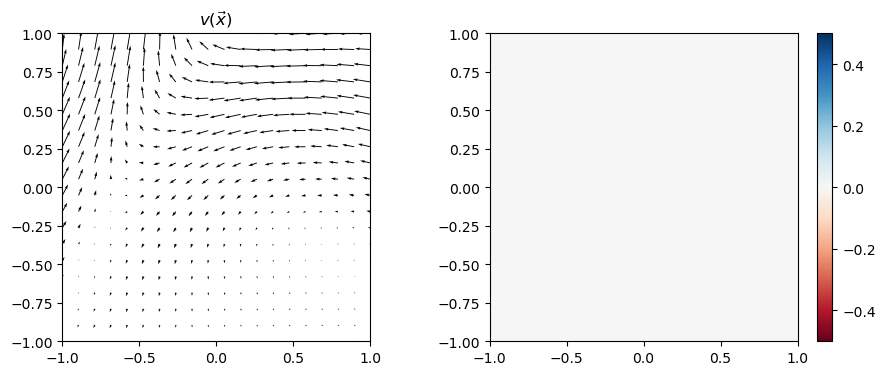

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# Quiver plot

U, V = vmap(v_vectorfield_construction)(x_mesh_quiver).T
X, Y = x_grid_quiver, y_grid_quiver
ax[0].quiver(X, Y, U, V)
ax[0].set_aspect(1.)
ax[0].set_title(r"$v(\vec x)$")
ax[0].set_xlim(-extent, extent)
ax[0].set_ylim(-extent, extent)

# Divergence

im = ax[1].imshow(
    rearrange(
        jnp.trace(vmap(jacfwd(v_vectorfield_construction))(x_mesh), axis1 = 1, axis2 = 2), 
        "(x y) -> x y", x = n_grid), 
        vmin = -0.5, vmax = 0.5, cmap = 'RdBu', 
                  extent = [-extent, extent, -extent, extent])

fig.colorbar(im, ax = ax[1])

### Alternative: streamplot

- Visualise streamplot where linewidth corresponds to magnitude and color corresponds to divergence.
- https://matplotlib.org/stable/gallery/images_contours_and_fields/plot_streamplot.html

TypeError: streamplot() got an unexpected keyword argument 'cmin'

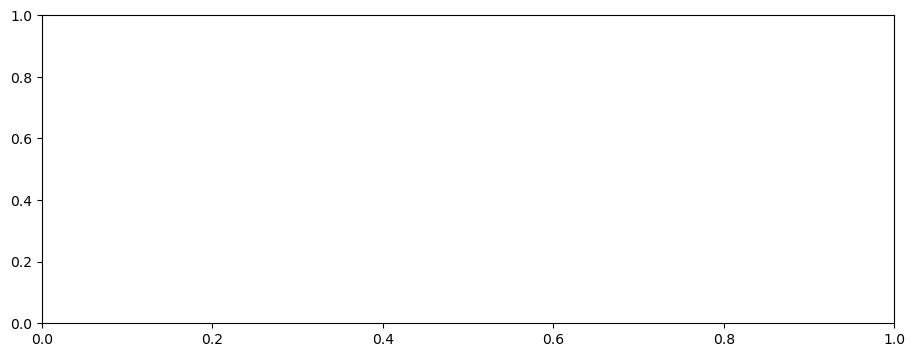

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (11, 4))

U_flat, V_flat = vmap(v_vectorfield_construction)(x_mesh_quiver).T
U = U_flat.reshape(n_grid_quiver, n_grid_quiver)
V = V_flat.reshape(n_grid_quiver, n_grid_quiver)

# magnitude: square each element to remove negative direction, then square root
mag = np.array(jnp.sqrt(U**2 * V**2))
lw = np.array(mag * 5 / jnp.max(mag)) # normalise, can't be jax array

v_div = np.array(rearrange(
    jnp.trace(vmap(jacfwd(v_vectorfield_construction))(x_mesh_quiver), axis1 = 1, axis2 = 2), 
    "(x y) -> x y", x = n_grid_quiver))

X, Y = x_grid_quiver, y_grid_quiver
ax.streamplot(X, Y, U, V, linewidth = lw, color = v_div, cmap = "coolwarm")
# coolwarm is diverging but has grey in middle
# add norm
ax.set_aspect(1.)
ax.set_title(r"$v(\vec x)$")
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)

plt.show()

# Break down components of A

In [41]:
# Transpose so shape is (2, 2, 400) and we can devide it up
# UA shape (2, 400)
# UA, VA = vmap(A_vectorfield_construction)(x_mesh_quiver).T

N22 = vmap(A_vectorfield_construction)(x_mesh_quiver)

A1UA = N22[:, 0, 0] # all points, first row, U
A1VA = N22[:, 0, 1] # all points, first row, V

A2UA = N22[:, 1, 0] # all points, second row, U
A2VA = N22[:, 1, 1] # all points, second row, V

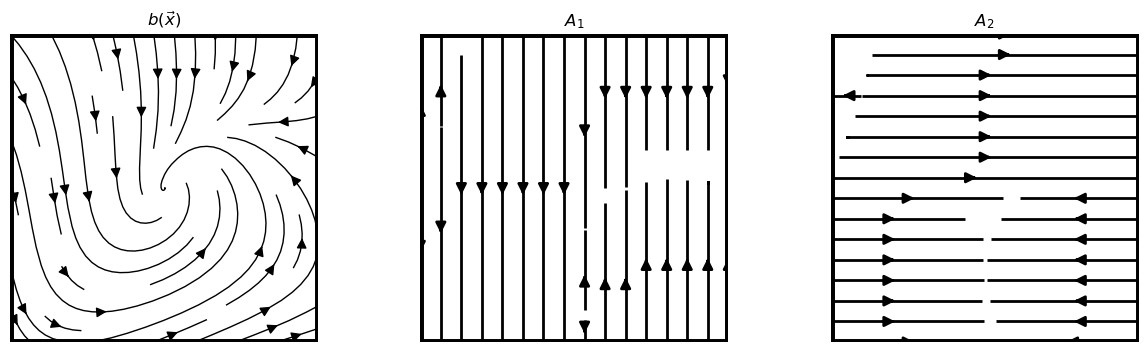

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

U, V = vmap(b_for_jac)(x_mesh_quiver).T

# If you have a JAX array, convert it to NumPy array first
x_mesh_quiver_np = jnp.asarray(x_mesh_quiver).tolist()  # Convert to regular numpy array
x_mesh_quiver_np = np.array(x_mesh_quiver_np)
x_mesh_quiver_np = np.nan_to_num(x_mesh_quiver_np) 

# Convert to standard NumPy array
X, Y = x_mesh_quiver_np.T

ax[0].set_title(r"$b(\vec x)$")
ax[0].set_xlim(- extent, extent)
ax[0].set_ylim(- extent, extent)
ax[0].set_aspect(1)
ax[0].axis('off') # removes borders and ticks
ax[0].streamplot(x_grid_quiver,
                 y_grid_quiver,
                 V.reshape(n_grid_quiver, n_grid_quiver),
                 U.reshape(n_grid_quiver, n_grid_quiver),
                 density = 0.55, arrowsize = 1.5, linewidth = 1, color = 'k')
rect = patches.Rectangle((- extent, - extent), 2*extent, 2*extent, linewidth = 5, edgecolor = 'k', facecolor = 'none')
ax[0].add_patch(rect)

ax[1].set_title(r"$A_1$")
ax[1].set_xlim(- extent, extent)
ax[1].set_ylim(- extent, extent)
ax[1].set_aspect(1)
ax[1].axis('off') # removes borders and ticks
ax[1].streamplot(x_grid_quiver,
                 y_grid_quiver,
                 A1UA.reshape(n_grid_quiver, n_grid_quiver),
                 A1VA.reshape(n_grid_quiver, n_grid_quiver),
                 density = 0.55, arrowsize = 1.5, linewidth = 2, color = 'k')
rect = patches.Rectangle((- extent, - extent), 2*extent, 2*extent, linewidth = 5, edgecolor = 'k', facecolor = 'none')
ax[1].add_patch(rect)

ax[2].set_title(r"$A_2$")
ax[2].set_xlim(- extent, extent)
ax[2].set_ylim(- extent, extent)
ax[2].set_aspect(1)
ax[2].axis('off') # removes borders and ticks
ax[2].streamplot(x_grid_quiver,
                 y_grid_quiver,
                 A2UA.reshape(n_grid_quiver, n_grid_quiver),
                 A2VA.reshape(n_grid_quiver, n_grid_quiver),
                 density = 0.55, arrowsize = 1.5, linewidth = 2, color = "k")
rect = patches.Rectangle((- extent, - extent), 2*extent, 2*extent, linewidth = 5, edgecolor = 'k', facecolor = 'none')
ax[2].add_patch(rect)

plt.show()

# To do

- divergence color on streamplot https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.streamplot.html
- check out orientation of X, Y, U, V
- We need a batch-NN for this